# Intro

## Data Explanation
I decided to use the behavioral dataset from the Human Connectome Project (HCP), which includes demographic information, performance on various tasks, and measures of brain structure/function for 1206 young participants (ages 22-35). 

The HCP data is open-access: the reference manual can be found [here](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf) and the data can be found [here](http://db.humanconnectome.org/) if you're interested. You will need to register an account to access the data, but that process should be straightforward.

## Replication Notes
I downloaded the data on my google drive [here](https://drive.google.com/file/d/1-F5s908KDLcbfDlN1BYOBWKhe1E4tqWC/view?usp=sharing ), so to replicate the results of this notebook, you can simply follow that link and download the `HCP-behavioral.csv` file to your own Google Drive. Just make sure that when you're reading the file (in the first code cell below), the path is correct. I put my file in a folder called `Data`, but you can put yours wherever, as long as the path argument for the `read_csv()` function is specific to the location of your version of `HCP-behavioral.csv`.

## Analysis Plan
Perform a chi-square test of independence on HCP data to see if there's an association between the time in which the participant was in the study and whether they completed all of the MRI scans.

If the test is significant, each comparison will tested and the Bonferroni correction will be applied.

# Data Preparation

## Importing Libraries, Mounting Gdrive, Loading Data
First, proper library/module imports must be done. Additionally, because I intend to analyze the data in Colab and have the HCP data on my Google Drive, I will mount my Google Drive onto the Google Colab runtime. See here for a guide.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import google.colab.drive as drive
import os
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data = pd.read_csv('gdrive/MyDrive/Data/HCP-behavioral.csv')
data

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,fMRI_Soc_PctCompl,fMRI_Rel_PctCompl,fMRI_Emo_PctCompl,3T_dMRI_Compl,3T_dMRI_PctCompl,dMRI_3T_ReconVrs,fMRI_3T_ReconVrs,7T_Full_MR_Compl,7T_RS-fMRI_Count,7T_RS-fMRI_PctCompl,7T_Full_Task_fMRI,7T_tMRI_PctCompl,fMRI_Movie_Compl,fMRI_Movie_PctCompl,fMRI_Ret_Compl,fMRI_Ret_PctCompl,7T_dMRI_Compl,7T_dMRI_PctCompl,7T_fMRI_Mov_Vrs,MEG_AnyData,MEG_FullProt_Compl,MEG_HeadModel_Avail,MEG_CortRibn_Avail,MEG_Anatomy_Avail,...,NEORAW_31,NEORAW_32,NEORAW_33,NEORAW_34,NEORAW_35,NEORAW_36,NEORAW_37,NEORAW_38,NEORAW_39,NEORAW_40,NEORAW_41,NEORAW_42,NEORAW_43,NEORAW_44,NEORAW_45,NEORAW_46,NEORAW_47,NEORAW_48,NEORAW_49,NEORAW_50,NEORAW_51,NEORAW_52,NEORAW_53,NEORAW_54,NEORAW_55,NEORAW_56,NEORAW_57,NEORAW_58,NEORAW_59,NEORAW_60,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,NaN,NaN,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,D,D,N,A,SA,N,N,A,A,A,D,N,D,A,A,N,A,SA,A,A,N,A,A,A,A,D,N,N,D,A,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,N,N,D,A,A,N,A,N,D,N,N,D,D,A,A,N,N,N,A,N,N,A,A,D,N,D,N,D,A,N,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r177,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,True,False,True,True,True,...,A,A,D,A,A,SD,A,N,D,A,D,D,N,D,D,A,A,D,A,A,D,SA,A,SD,D,D,D,D,SD,A,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r177,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,A,D,D,A,A,SD,A,SD,D,A,D,N,D,N,D,N,A,D,SA,A,D,A,A,N,D,N,D,A,A,A,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,True,4,100.0,True,100.0,True,100.0,True,100.0,True,100.0,2.0,False,False,False,False,False,...,SA,D,D,A,A,SD,D,N,A,A,SD,N,A,A,D,A,D,D,SA,A,SD,N,SA,SD,D,A,SA,SA,D,A,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r177,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,A,D,N,SA,A,D,A,A,D,A,D,D,N,N,SD,SD,A,D,SA,SA,D,SA,A,D,D,SD,SD,A,SD,SA,8.4,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76
1202,993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,A,D,SD,A,A,D,N,A,SD,SA,D,D,A,SD,A,A,D,SD,SA,SA,D,N,A,D,D,SD,D,D,SD,SA,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1203,994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,D,A,D,A,SA,N,N,SD,N,A,D,N,N,A,N,N,A,D,A,A,D,A,A,N,N,D,N,N,N,A,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76
1204,995174,S

## Selecting the Categorical IV
I want to see whether being in a particular release (`acquisition`) is associated with differences in completing all the fMRI scans (`3T_Full_MR_Compl`). Maybe earlier releases will have worse "retention" such that less people go through the full protocol. The reason could be that in the beginning of the study, researchers aren't as experienced.

### `Acquisition` from the HCP data dictionary:
- Acquisition: Quarter in which this subject's 3T and behavioral data (and MEG, if applicable) was initially acquired. Quarter is defined as relative to the start of HCP Phase II data collection. Q1 = 8/2012 - 10/2012 (Aug-Oct), Q2 = 11/2012 - 1/2013, Q3 = 2/2013 - 4/2013, Q4 = 5/2013 - 7/2013, Q5 = 8/2013 - 10/2013, etc.

In [4]:
data['Acquisition'].unique()
# 13 quarters * 3m per quarter = 39 months

array(['Q06', 'Q11', 'Q01', 'Q03', 'Q08', 'Q12', 'Q04', 'Q13', 'Q10',
       'Q02', 'Q07', 'Q09', 'Q05'], dtype=object)

## Creating Chi-square Contingency tables

In [5]:
acq_mricomp_ct = pd.crosstab(data['3T_Full_MR_Compl'], data['Acquisition'])
acq_mricomp_ct 
# True are those who fully completed the MRI scans
# False includes anyone who didn't complete all of the scans

Acquisition,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q09,Q10,Q11,Q12,Q13
3T_Full_MR_Compl,,,,,,,,,,,,,
False,18,17,26,31,28,23,25,24,23,13,26,34,29
True,36,55,72,83,77,90,59,79,79,76,77,64,42


In [6]:
acq_mricomp_ct.sum().sum()

1206

In [7]:
colsum = acq_mricomp_ct.sum(axis=0)
acq_mricomp_ct_percentages = acq_mricomp_ct/colsum
acq_mricomp_ct_percentages 

Acquisition,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q09,Q10,Q11,Q12,Q13
3T_Full_MR_Compl,,,,,,,,,,,,,
False,0.333333,0.236111,0.265306,0.27193,0.266667,0.20354,0.297619,0.23301,0.22549,0.146067,0.252427,0.346939,0.408451
True,0.666667,0.763889,0.734694,0.72807,0.733333,0.79646,0.702381,0.76699,0.77451,0.853933,0.747573,0.653061,0.591549


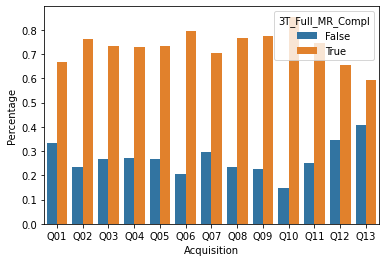

In [11]:
acq_mricomp_ct_percentages_ = acq_mricomp_ct_percentages.join(pd.DataFrame({'3T_Full_MR_Compl':['False', 'True']}))
acq_mricomp_ct_percentages_long = pd.melt(acq_mricomp_ct_percentages_, id_vars=['3T_Full_MR_Compl'], value_vars=list(acq_mricomp_ct_percentages_.columns[0:-1]), 
        var_name='Acquisition', value_name='Percentage')
sns.barplot(data=acq_mricomp_ct_percentages_long, x='Acquisition', y='Percentage', hue='3T_Full_MR_Compl')
plt.show()

# Analysis and Results

## Chi Square test

In [9]:
chi2_results = stats.chi2_contingency(acq_mricomp_ct)
print('chi-square val: ', chi2_results[0])
print('chi-square p value:', chi2_results[1])
print('chi-square DOF', chi2_results[2])
chi2_EV = pd.DataFrame(chi2_results[3])
print('chi-square expected counts:'.upper())
chi2_EV.set_axis(['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10',
       'Q11', 'Q12', 'Q13'], axis='columns', inplace=True)
chi2_EV

chi-square val:  23.15996635587404
chi-square p value: 0.026398171629130877
chi-square DOF 12
CHI-SQUARE EXPECTED COUNTS:


,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q09,Q10,Q11,Q12,Q13
0,14.19403,18.925373,25.759536,29.965174,27.599502,29.702322,22.079602,27.073798,26.810945,23.393864,27.073798,25.759536,18.662521
1,39.80597,53.074627,72.240464,84.034826,77.400498,83.297678,61.920398,75.926202,75.189055,65.606136,75.926202,72.240464,52.337479


## Multiple Comparisons and Bonferroni Correction

In [10]:
# list of all combinations for post-hoc chi-square comparisons
combinations_list = list(combinations(acq_mricomp_ct.columns, 2)) 
bonferroni_alpha = 0.05/len(combinations_list)
print(f"Results for {len(combinations_list)} Multiple Comparisons with Bonferroni Correction, alpha = {bonferroni_alpha:.3g}:")
for comb in combinations_list:
    df = acq_mricomp_ct[[comb[0], comb[1]]]
    chi2, p, dof, expected = stats.chi2_contingency(df, correction=False)
    # p=p/len(combinations_list)
    if p < 0.05/len(combinations_list): # Bonferroni correction alpha/n
        p_sig = "*"
    else:
        p_sig = 'n.s'
    print(f"{comb} Chi-square statistic: {chi2:.4f}, DOF: {dof}, p: {p:.4f} {p_sig}")

Results for 78 Multiple Comparisons with Bonferroni Correction, alpha = 0.000641:
('Q01', 'Q02') Chi-square statistic: 1.4538, DOF: 1, p: 0.2279 n.s
('Q01', 'Q03') Chi-square statistic: 0.7833, DOF: 1, p: 0.3761 n.s
('Q01', 'Q04') Chi-square statistic: 0.6687, DOF: 1, p: 0.4135 n.s
('Q01', 'Q05') Chi-square statistic: 0.7708, DOF: 1, p: 0.3800 n.s
('Q01', 'Q06') Chi-square statistic: 3.3231, DOF: 1, p: 0.0683 n.s
('Q01', 'Q07') Chi-square statistic: 0.1955, DOF: 1, p: 0.6584 n.s
('Q01', 'Q08') Chi-square statistic: 1.8197, DOF: 1, p: 0.1774 n.s
('Q01', 'Q09') Chi-square statistic: 2.1194, DOF: 1, p: 0.1454 n.s
('Q01', 'Q10') Chi-square statistic: 6.9416, DOF: 1, p: 0.0084 n.s
('Q01', 'Q11') Chi-square statistic: 1.1496, DOF: 1, p: 0.2836 n.s
('Q01', 'Q12') Chi-square statistic: 0.0286, DOF: 1, p: 0.8656 n.s
('Q01', 'Q13') Chi-square statistic: 0.7377, DOF: 1, p: 0.3904 n.s
('Q02', 'Q03') Chi-square statistic: 0.1872, DOF: 1, p: 0.6652 n.s
('Q02', 'Q04') Chi-square statistic: 0.2957, DO

# Summary
A chi-square test of independence was conducted to see if there was an association between a when a participant was in the study (13 quarters) and whether they completed the MRI scans (yes/no). Results showed a significant association between time in study and whether they completed the MRI scans, $\chi^2$ (12, N = 1206) = 23.159, p = 0.026.

Multiple comparisons test using Bonferroni correction was conducted, which showed that only the difference between Q10 (11/2014 - 1/2015) and Q13 (last quarter; 8/2015 - 10/2015) was significant, $\chi^2$ (1, N = 1206) = 14.044, p = 0.026.

One interpretation is just that in the final quarter of the HCP study, there were many participants who did not fully complete the study because there was a set time for data collection to end. Rather than to wait for all participants to come back for their final scans, researchers just opted to stop the study with what they had at the time, regardless of whether all participants came back or not.